In [1]:
import numpy as np
import pandas as pd
import gensim
import glob, re, io
from collections import Counter
from gensim.models import word2vec
from argparse import Namespace
from nltk.tokenize import wordpunct_tokenize as tokenize


## სტატიების წაკითხვა

ვკითხულობთ სტატიებს (სულ ~185 000) და ვუკეთებთ მარტივ ტოკენიზაციას. 

დამატებითი 3 ცალი replace იმიტომ არის გამოყენებული, რომ ტოკენიზატორი არ ითვალისწინებს მაგ შემთხვევებს. 

In [2]:
corpus = []
for ind, filename in enumerate(glob.glob("../data/whole-data/*")):
    if ind % 5000 == 0:
        print(ind, 'files read')
    fd = io.open(filename, mode="r", encoding="utf-8")
    text = fd.read() 
    text = text.replace('"', ' " ')
    text = text.replace('”', ' " ')
    text = text.replace('“', ' " ')
    tokenized = tokenize(text)
    corpus.append(tokenized)
    fd.close()


0 files read
5000 files read
10000 files read
15000 files read
20000 files read
25000 files read
30000 files read
35000 files read
40000 files read
45000 files read
50000 files read
55000 files read
60000 files read
65000 files read
70000 files read
75000 files read
80000 files read
85000 files read
90000 files read
95000 files read
100000 files read
105000 files read
110000 files read
115000 files read
120000 files read
125000 files read
130000 files read
135000 files read
140000 files read
145000 files read
150000 files read
155000 files read
160000 files read
165000 files read
170000 files read
175000 files read
180000 files read
185000 files read


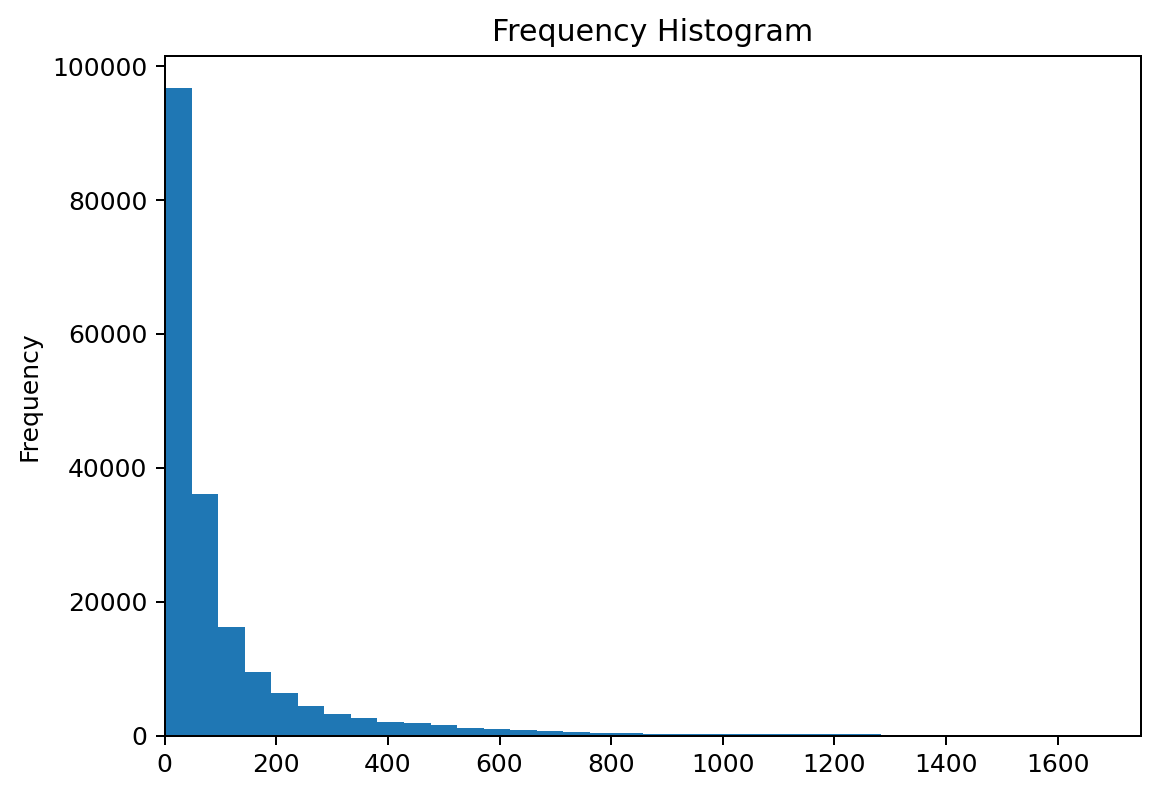

In [3]:
# რა სიგრძის სტატიები გვაქვს?

import matplotlib.pyplot as plt

sizes = [len(doc) for doc in corpus]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':180})

# Plot Histogram on x
plt.hist(sizes, bins=500)
plt.xlim([0, 1750])
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');


ის სტატიები, რომლებშიც ცოტა სიტყვაა, ჯობს გადავაგდოთ, რადგან, დიდი ალბათობით, არ ექნებათ წესიერი კონტექსტი. 

შესაბამისად, არ ვითვალისწინებთ სტატიებს, რომლებიც შედგება 25ზე ნაკლები ტოკენისგან.

In [4]:
len_before = len(corpus)
corpus = [doc for doc in corpus if len(doc) > 25]
len_after = len(corpus)
print('წაშლილი სტატიების რაოდენობა -', len_before-len_after)

წაშლილი სტატიების რაოდენობა - 70947


### უნიკალური სიტყვების რაოდენობა და მათი სიხშირე 

In [5]:
word_cnt = Counter()
for doc in corpus:
    word_cnt.update(doc)
    
print('უნიკალური სიტყვების რაოდენობა -', len(word_cnt))

უნიკალური სიტყვების რაოდენობა - 983662


In [6]:
print('ყველაზე ხშირი ტოკენები')
print(word_cnt.most_common()[:20])

ყველაზე ხშირი ტოკენები
[('.', 1764019), (',', 1701730), ('და', 702092), ('-', 576124), ('"', 362739), ('(', 258641), ('—', 192165), ('წელს', 160851), ('„', 159174), ('წლის', 158886), (')', 144781), ('იყო', 125888), ('რომელიც', 92327), (':', 87419), ('ის', 86598), ('რომ', 84309), ('მისი', 78196), ('შემდეგ', 76228), ('ამ', 67071), (').', 61904)]


ცხადია ამდენ უნიკალურ სიტყვას ვერ გამოვიყენებთ, უმეტესობა მცირე რაოდენობით გვხვდება კორპუსში. 

In [7]:
word_cnt.most_common()[90000:90010]

[('მოჰსენ', 15),
 ('PS2', 15),
 ('სტოიკოსების', 15),
 ('ექსლი', 15),
 ('ჟესტის', 15),
 ('ციკლოპს', 15),
 ('ფერებთან', 15),
 ('ჰელიქტიტების', 15),
 ('სუბსტრუქციაზე', 15),
 ('ტოშე', 15)]

მგონი კარგი იქნება min_count-ის მნიშვნელობა იყოს 10-15 ფარგლებში. ისე, რომ დაახლოებით 90 000 უნიკალური ტოკენის გამოყენება გამოგვივიდეს.

რაც შეეხება ემბედინგის ზომას, რადგან არ გვაქვს დიდი კორპუსი, გადავწყვიტეთ მცირე ზომა აგვერჩია (100 და 128)

ფანჯრის ზომა კი ავიღეთ 3 და 4

In [8]:
# არგუმენტები სხვადასხვა მოდელისთვის

args1 = Namespace(
    embed_size = 100,
    window_size = 4,
    min_count = 15,
    skip_gram = 1,
    model_name = 'w2vemb100wind4'
)

args2 = Namespace(
    embed_size = 128,
    window_size = 4,
    min_count = 15,
    skip_gram = 1,
    model_name = 'w2vemb128wind4'
)

args3 = Namespace(
    embed_size = 100,
    window_size = 3,
    min_count = 15,
    skip_gram = 1,
    model_name = 'w2vemb100wind3'
)

args4 = Namespace(
    embed_size = 128,
    window_size = 3,
    min_count = 15,
    skip_gram = 1,
    model_name = 'w2vemb128wind3'
)

args = [args1, args2, args3, args4]


In [9]:
output_dir = '../resources/word2vec/'
def train_model(corpus, args):
    print('training model -', args.model_name)
    model = word2vec.Word2Vec(corpus, size=args.embed_size, window=args.window_size, 
                              min_count=args.min_count, sg=args.skip_gram)
    model.save(output_dir + args.model_name + '.model')


In [10]:
for arg in args:
    train_model(corpus, arg)
print('კანეც')

training model - w2vemb100wind4
კანეც
training model - w2vemb128wind4
კანეც
training model - w2vemb100wind3
კანეც
training model - w2vemb128wind3
კანეც
